# Planetary Computer Data: SCALING TEST

In [ ]:
#!mamba install -y py3dep
#!mamba install -y astropy
#!mamba install -y rasterio

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import pystac
import pystac_client
import stackstac
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime
import matplotlib
import ipyleaflet
import sys
import os
import dask_gateway
import planetary_computer
from rechunker import rechunk
sys.path.append('../sar_snowmelt_timing')
import s1_rtc_bs_utils
import contextily as ctx
import rioxarray as rxr
import skimage
#from astropy.convolution import Gaussian2DKernel
#from astropy.convolution import convolve

In [2]:
#os.environ["DASK_DISTRIBUTED__COMM__TIMEOUTS__CONNECT"]="300s"
#os.environ["DASK_DISTRIBUTED__COMM__TIMEOUTS__TCP"]="800s"
#os.environ["DASK_DISTRIBUTED__COMM__RETRY__DELAY__MIN"]="400s"
#os.environ["DASK_DISTRIBUTED__COMM__RETRY__DELAY__MAX"]="600s"

In [3]:
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [4]:
cluster = dask_gateway.GatewayCluster(shutdown_on_close=False) # 
client = cluster.get_client()
cluster.adapt(minimum=2, maximum=100)
print(client.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.4d50b7196ac44726874c71c11f10c592/status


In [8]:
#gj = '../input/shapefiles/mt_baker.geojson'
#gj = '../input/shapefiles/mt_st_helens.geojson'
gj = '../input/shapefiles/olympics.geojson'
#gj = '../input/shapefiles/olympic_peninsula.geojson'
#gj = '../input/shapefiles/wa.geojson'
bbox_gdf = gpd.read_file(gj)

In [9]:
ts_ds = s1_rtc_bs_utils.get_s1_rtc_stac_pc(bbox_gdf,start_time='2019-01-01',end_time='2019-12-31',polarization='all',resolution=40) # special incrimnets? 320.....   80 for peninsula, 40,30 works for olympics feb1-sept30 worked

In [10]:
ts_ds

<xarray.DataArray 'stackstac-7f65ecabeca5d98b24e078e4b82bea6d' (time: 172,
                                                                band: 2,
                                                                y: 1582, x: 1987)>
dask.array<getitem, shape=(172, 2, 1582, 1987), dtype=float64, chunksize=(1, 1, 1023, 1023), chunktype=numpy.ndarray>
Coordinates: (12/39)
  * time                                   (time) datetime64[ns] 2019-01-04T0...
    id                                     (time) <U66 'S1B_IW_GRDH_1SDV_2019...
  * band                                   (band) <U2 'vh' 'vv'
  * x                                      (x) float64 4.202e+05 ... 4.996e+05
  * y                                      (y) float64 5.325e+06 ... 5.262e+06
    sar:product_type                       <U3 'GRD'
    ...                                     ...
    platform                               <U11 'SENTINEL-1B'
    s1:processing_level                    <U1 '1'
    raster:bands                           object {'nodata': -32768, 'data_ty...
    title                                  (band) <U41 'VH: vertical transmit...
    description                            (band) <U173 'Terrain-corrected ga...
    epsg                                   int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(420120, 5262000, 499640, 5325...
    crs:         epsg:32610
    transform:   | 40.00, 0.00, 420120.00|\n| 0.00,-40.00, 5325320.00|\n| 0.0...
    resolution:  40

In [11]:
ts_compute = ts_ds.compute()

In [12]:
runoffs = s1_rtc_bs_utils.get_runoff_onset(ts_compute,return_seperate_orbits=True,return_seperate_polarizations=True)

Using relative orbits: [ 13  35  86 137]


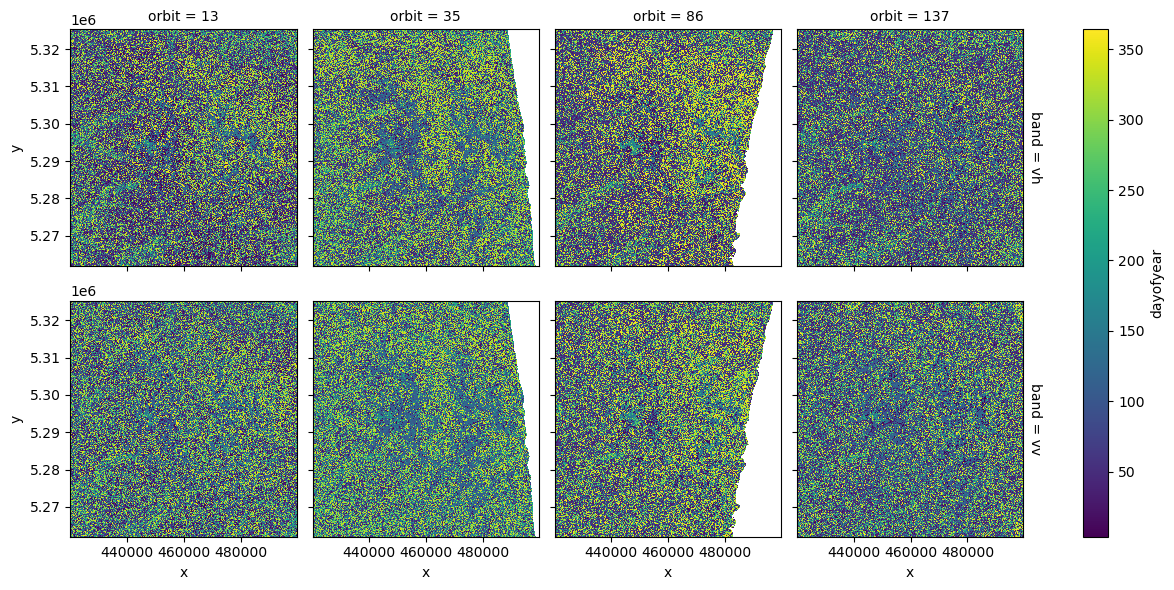

In [13]:
runoffs.dt.dayofyear.plot(col='orbit',row='band')

In [ ]:
runoffs = s1_rtc_bs_utils.get_runoff_onset(ts_compute,return_seperate_orbits=False,return_seperate_polarizations=False)

Using relative orbits: [ 13  35  86 137]


In [ ]:
f,ax=plt.subplots(figsize=(10,10))
runoffs.dt.dayofyear.plot(ax=ax)

In [ ]:
stac_endopoint = 'https://services.terrascope.be/stac/' #https://github.com/ESA-WorldCover/esa-worldcover-datasets/blob/main/notebooks/01-Explore_dataset_STAC.ipynb

collection_ids = {2020: 'urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1',
                  2021: 'urn:eop:VITO:ESA_WorldCover_10m_2021_AWS_V2'}

# WSG84 coordinates of Mol, Belgium
bbox = [5.046776, 51.151453, 5.181290, 51.241861]
bbox = bbox_gdf.total_bounds

client = pystac_client.Client.open(stac_endopoint)

# Let's query products for the 2021 map 
year = 2021
search_results = client.search(
    collections=[collection_ids[year]],
    bbox=bbox
)

# Search results fetched and represented as dictionary
results = search_results.get_all_items()

In [ ]:
results

In [ ]:
stack_lc = stackstac.stack(results, bounds_latlon=bbox, epsg=32610, resolution=40)

In [ ]:
stack_lc

In [ ]:
stack_lc = stack_lc.min(dim='time')

In [ ]:
f,ax=plt.subplots(figsize=(10,10))
stack_lc.plot()

In [ ]:
f,ax=plt.subplots(figsize=(10,10))
stack_lc.where(stack_lc>10).plot(ax=ax)

In [ ]:
mask = stack_lc.where(stack_lc>10).squeeze() # classses here: https://esa-worldcover.s3.eu-central-1.amazonaws.com/v200/2021/docs/WorldCover_PUM_V2.0.pdf

In [ ]:
mask.plot()

In [ ]:
#ts_ds = ts_ds.astype(np.float32)

In [ ]:
ts_ds = ts_ds.where(mask!=np.nan).compute()

In [ ]:
ts_ds

In [ ]:
runoffs = s1_rtc_bs_utils.get_runoff_onset(ts_ds,return_seperate_orbits=True,return_seperate_polarizations=True)

In [ ]:
runoffs.dt.dayofyear.plot(col='orbit',row='band')

In [ ]:
runoffs = []

In [ ]:
runoffs = s1_rtc_bs_utils.get_runoff_onset(ts_ds,return_seperate_orbits=False,return_seperate_polarizations=False)

In [ ]:
f,ax=plt.subplots(figsize=(10,10))
runoffs.dt.dayofyear.plot(ax=ax)

In [ ]:
runoffs.dt.dayofyear.plot(col='orbit',row='band')

In [ ]:
runoffs.dt.dayofyear.plot(col='band')

In [ ]:
#runoff_1 = runoffs.astype(np.int64)

In [ ]:
#runoff_2 = runoff_1.where(runoff_1>0)

In [ ]:
#runoff_3 = runoff_2.median(axis=2,skipna=True)

In [ ]:
#runoff_4 = runoff_3.astype('datetime64[ns]')

In [ ]:
runoffs = s1_rtc_bs_utils.get_runoff_onset(ts_ds,combine_orbits='median')

In [ ]:
f,ax=plt.subplots(figsize=(30,30))
runoffs.dt.dayofyear.plot(ax=ax,vmin=0,vmax=365,cmap='twilight')

In [ ]:
f,ax=plt.subplots(figsize=(30,30))
runoffs.dt.dayofyear.plot(ax=ax,vmin=0,vmax=365)

In [ ]:
summer_ndvi_ds = s1_rtc_bs_utils.get_median_ndvi(ts_ds,start_time='2019-07-30',end_time='2019-09-09')

In [ ]:
f,ax=plt.subplots(figsize=(20,20))
runoffs.where(summer_ndvi_ds<1).dt.dayofyear.plot(ax=ax,vmin=90,vmax=200,cmap='inferno')
ax.set_xlim([435000,491000])
ax.set_ylim([5.27E6,5.32E6])

In [ ]:
#ndwi_median = s1_rtc_bs_utils.get_median_ndwi(ts_ds,start_time='2018-11-01',end_time='2019-03-16')
#summer_ndvi_ds = s1_rtc_bs_utils.get_median_ndvi(ts_ds,start_time='2019-07-30',end_time='2019-09-09')

In [ ]:
#f,ax=plt.subplots(figsize=(30,30))
#ndwi_median.plot(ax=ax,cmap='RdBu')

In [ ]:
cop30_dem_hs = rxr.open_rasterio('olympic_COP30_lzw-adj_proj_multi_hs.tif')

In [ ]:
f,ax=plt.subplots(figsize=(30,30))
cop30_dem_hs.plot(ax=ax,cmap='gray',alpha=1)
runoffs.dt.dayofyear.plot(ax=ax,vmin=90,vmax=250,cmap='inferno',alpha=0.7)

In [ ]:
summer_ndvi_ds.rio.crs

In [ ]:
runoffs.rio.set_crs(summer_ndvi_ds.rio.crs)

In [ ]:
f,ax=plt.subplots(figsize=(15,15))
runoffs.where(summer_ndvi_ds<0.8).dt.dayofyear.plot(ax=ax,vmin=90,vmax=200,cmap='inferno',alpha=1,cbar_kwargs={'shrink':0.71,'label':'Day of Year'})
ax.set_xlim([435000,491000])
ax.set_ylim([5.27E6,5.32E6])
ctx.add_basemap(ax=ax, crs=runoffs.rio.crs, source=ctx.providers.Stamen.Terrain, attribution=False)

ax.set_title('2019 Snowmelt Runoff Onset Date for The Olympic Mountains')
ax.set_aspect('equal')
ax.axis('off')

In [ ]:
image_count = ts_ds.count(dim='time')
image_count_yearlyavg = 365.25/image_count

In [ ]:
f,ax=plt.subplots(figsize=(10,10))
image_count_yearlyavg.plot(ax=ax,vmin=0,vmax=13)

In [ ]:
ts_ds.where(summer_ndvi_ds<0.2).mean(dim=['x','y'])

In [ ]:
f,ax=plt.subplots()
ts_ds.where(summer_ndvi_ds<0.2).mean(dim=['x','y']).plot(ax=ax,x='time',hue='sat:orbit_state')
# trying to https://xarray.pydata.org/en/v0.10.1/auto_gallery/plot_lines_from_2d.html

In [ ]:
f,ax=plt.subplots(4,2,figsize=(30,30))
runoffs.where(summer_ndvi_ds<0.2).dt.dayofyear.plot(ax=ax[0,0],vmin=90,vmax=200,cmap='inferno')
ctx.add_basemap(ax=ax[0,0], crs=summer_ndvi_ds.rio.crs, source=ctx.providers.Stamen.Terrain, attribution=False)

runoffs.where((summer_ndvi_ds>0.2)&(summer_ndvi_ds<0.5)).dt.dayofyear.plot(ax=ax[1,0],vmin=90,vmax=200,cmap='inferno')
ctx.add_basemap(ax=ax[1,0], crs=summer_ndvi_ds.rio.crs, source=ctx.providers.Stamen.Terrain, attribution=False)

runoffs.where((summer_ndvi_ds>0.5)&(summer_ndvi_ds<0.82)).dt.dayofyear.plot(ax=ax[2,0],vmin=90,vmax=200,cmap='inferno')
ctx.add_basemap(ax=ax[2,0], crs=summer_ndvi_ds.rio.crs, source=ctx.providers.Stamen.Terrain, attribution=False)

runoffs.where(summer_ndvi_ds>0.82).dt.dayofyear.plot(ax=ax[3,0],vmin=90,vmax=200,cmap='inferno')
ctx.add_basemap(ax=ax[3,0], crs=summer_ndvi_ds.rio.crs, source=ctx.providers.Stamen.Terrain, attribution=False)

#ts_ds.where(summer_ndvi_ds<0.2).groupby('sat:relative_orbit').mean(dim=['x','y']).plot(ax=ax[0,1])

In [ ]:
runoffs_std = s1_rtc_bs_utils.get_runoff_onset(ts_ds,return_seperate_orbits=True)

In [ ]:
runoffs_std.dt.dayofyear.plot(col='orbit',size=8,col_wrap=2,cmap='inferno')

In [ ]:
kernel = Gaussian2DKernel(x_stddev=1)
average_all_orbits = np.zeros([1582,1987])
for i in runoffs_std.orbit:
    astropy_conv = convolve(runoffs_std.sel(orbit=i).dt.dayofyear, kernel)
    average_all_orbits = astropy_conv+average_all_orbits
average_all_orbits = average_all_orbits/4

In [ ]:
f,ax=plt.subplots(figsize=(30,30))
runoff_date = ax.imshow(average_all_orbits,cmap='inferno',vmin=0,vmax=365)
f.colorbar(runoff_date,ax=ax)

In [ ]:
f,ax=plt.subplots(figsize=(10,10))
runoffs_std = runoffs_std.dt.dayofyear.std(dim='orbit')
runoffs_std.where(runoffs_std<60).plot(ax=ax,vmin=0,vmax=60)

In [ ]:
f,ax=plt.subplots()
runoffs.where(summer_ndvi_ds>0.5).dt.dayofyear.plot(ax=ax,vmin=90,vmax=200,cmap='inferno')

In [ ]:
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

In [ ]:
kernel = Gaussian2DKernel(x_stddev=1.5)

In [ ]:
#astropy_conv = convolve(runoffs.where(summer_ndvi_ds>0.5).dt.dayofyear, kernel)
astropy_conv = convolve(runoffs.where((summer_ndvi_ds>0.5)&(summer_ndvi_ds<0.75)).dt.dayofyear, kernel)

In [ ]:
astropy_conv

In [ ]:
f,ax=plt.subplots(figsize=(10,10))
ax.imshow(astropy_conv,cmap='inferno',vmin=90,vmax=200)
ax.imshow(runoffs.where(summer_ndvi_ds<0.5).dt.dayofyear,cmap='inferno',vmin=90,vmax=200)

#runoffs.where(summer_ndvi_ds<0.5).dt.dayofyear.plot(ax=ax,vmin=90,vmax=200,cmap='inferno')

In [ ]:
ts_ds

In [ ]:
summer_ndvi_ds

In [ ]:
runoffs

In [ ]:
pixel_entropies = xr.apply_ufunc(skimage.measure.shannon_entropy,runoffs)

In [ ]:
#ts_ds = ts_ds.chunk({'time': 163,'y': 64,'x': 64})
#ts_ds = ts_ds.chunk({'time': 810,'y': 64,'x': 64})
#target_chunks = (163, 128, 128)
#max_mem = '1MB'
#target_store = 'air_rechunked.zarr'
#ts_ds = rechunk(ts_ds,target_chunks,max_mem,target_store)

In [ ]:
ts_ds

In [ ]:
#ts_ds.argmin(dim='time') #maybe dont need to do arg min?

In [ ]:
%%time
ts_ds = ts_ds.compute() # for Olympic Peninsula 0:5 works, 0:50 doesnt .isel(time=slice(0,25)) kernel restarts

In [ ]:
ts_ds

In [ ]:
%%time
ts_ds = ts_ds.dropna('time',how='all')

In [ ]:
ts_ds

In [ ]:
%%time
runoff = s1_rtc_bs_utils.get_runoff_onset(ts_ds,return_seperate_orbits=True).dt.dayofyear

In [ ]:
runoff

In [ ]:
runoff.plot(col='orbit')

In [ ]:
f,ax=plt.subplots()
runoff.plot(ax=ax,vmin=60,vmax=365)

In [ ]:
#### CODE FOR DEVELOPMENT-- THIS RELOADS s1_rtc_bs_utils MODULE
sys.modules.pop('s1_rtc_bs_utils')
import s1_rtc_bs_utils

In [ ]:
#!mamba install -y py3dep

#!mamba update -y dask-gateway
#!mamba update -y dask-distributed
#!mamba update -y dask

#from distributed import Client
#dask_gateway.config.set({"distributed.comm.timeouts.tcp": "120s"})
#os.environ["DASK_DISTRIBUTED__COMM__TIMEOUTS__CONNECT"]="100s"
#os.environ["DASK_DISTRIBUTED__COMM__TIMEOUTS__TCP"]="600s"
#os.environ["DASK_DISTRIBUTED__COMM__RETRY__DELAY__MIN"]="1s"
#os.environ["DASK_DISTRIBUTED__COMM__RETRY__DELAY__MAX"]="60s"



#dask_gateway.config.set({"distributed.comm.timeouts.tcp": "120s"})


# #gj = '../input/shapefiles/wa.geojson'

#f,ax=plt.subplots(figsize=(30,7))
#s1_rtc_bs_utils.plot_sentinel1_acquisitons(ts_ds,ax=ax)

#cluster.scale(10)
#cluster.adapt(minimum=400, maximum=400)
#gateway = Gateway()
#options = gateway.cluster_options()
#options.worker_cores = 100

#### CODE FOR DEVELOPMENT-- THIS RELOADS s1_rtc_bs_utils MODULE
#sys.modules.pop('s1_rtc_bs_utils')
#import s1_rtc_bs_utils